# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 2. Поиск по образцу.**

Смените рабочую директорию с помощью команды `chdir()`. Для этого передайте этой команде свой путь до каталога, в котором содержатся материалы второй практической работы. После выполнения этой команды все последующие операции с файлами и каталогами будут производиться относительно указанного каталога.

In [25]:
import sys
import os

In [26]:
# Путь к директории, где находится файл metrics.py
module_path = r'C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\Анализ и прогнозирование временных рядов методами искусственного интеллекта (очная)\Практическая 2\TimeSeriesCourse-main\practice\02 Similarity search\modules'

In [27]:
# Добавляем этот путь в sys.path
if module_path not in sys.path:
    sys.path.append(module_path)

In [28]:
import sys
print(sys.version)

3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:27:10) [MSC v.1938 64 bit (AMD64)]


In [29]:
# Теперь можно импортировать функции из metrics.py
from metrics import ED_distance, norm_ED_distance, DTW_distance

In [30]:
import os

practice_dir_path = r'C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\Анализ и прогнозирование временных рядов методами искусственного интеллекта (очная)\Практическая 2\TimeSeriesCourse-main\practice\02 Similarity search'
os.chdir(practice_dir_path)

Выполните команды, которые автоматически перезагружают все импортированные модули при их изменении.

In [31]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Импортируйте библиотеки и модули, необходимые для реализации практической работы 2.

In [33]:
# !pip install mass-ts
# !pip install sktime

In [34]:
# Импорт всех нужных функций из metrics.py
from metrics import ED_distance, norm_ED_distance, DTW_distance, z_normalize

In [35]:
import numpy as np
import pandas as pd
import math
import timeit
import random
import mass_ts as mts
from IPython.display import display

# Импортируем необходимые функции и модули из локальных файлов
from modules.distance_profile import brute_force
from modules.prediction import *
from modules.bestmatch import *
from modules.utils import *
from modules.plots import *

## **Часть 1.** Поиск по образцу на основе вычисленного профиля расстояния.

**Задача поиска по образцу (subsequence matching)** заключается в нахождении $topK$ наиболее похожих подпоследовательностей временного ряда $T$ длины $n$ на заданный пользователем существенно более короткий временной ряд $Q$ длины $m$, называемый запросом, в смысле некоторой функции расстояния, $m \ll n$. При этом среди найденных подпоследовательностей не должно быть тривиальных совпадений.

Две подпоследовательности $T_{i,m}$ и $T_{j,m}$ временного ряда $T$ являются **тривиальными совпадениями (trivial matches)**, если они пересекаются:
\begin{equation}
|i-j| \leqslant m.
\end{equation}

В общем случае условие пересечения записывается как $|i-j| \leqslant \xi m$, где задаваемый экспертом вещественный параметр $\xi$ $(0 < \xi \leqslant 1)$ имеет типичные значения 0.25, 0.5 или 1.

Одним из вариантов решения данной задачи является вычисление профиля расстояния. Под **профилем расстояния** $DistProfile\in \mathbb{R}^{n-m+1}$ понимается вектор, содержащий расстояния между подпоследовательностями временного ряда $T \in \mathbb{R}^n$ и запросом $Q \in \mathbb{R}^m$, вычисленные с помощью некоторой неотрицательной симметричной функции расстояния $dist(\cdot,\cdot)$:  
\begin{equation}
DistProfile(i) = dist(Q, T_{i,m}), \quad 1 \leqslant i \leqslant n-m+1.
\end{equation}

На основе вычисленного профиля расстояния в качестве $topK$ похожих подпоследовательностей ряда берутся те, которые имеют наименьшие расстояния до запроса:
\begin{equation}
C_{match} = \{T_{i,m}^k\}_{k=1}^{topK},\; где \; T_{i,m}^k \in T, \; i = argsort(DistProfile)(k), \; 1 \leqslant i \leqslant n-m+1.
\end{equation}

В части 1 практической работы 2 вы рассмотрите несколько алгоритмов вычисления профиля расстояния на примере алгоритмов грубой силы и MASS, а также примените результаты их выполнения для решения задачи поиска по образцу. В таблице ниже представлено их тезисное описание.

| <h5> **Алгоритм** </h5> | <h5> **Описание** </h5> | <h5> **Вычислительная <br> сложность** </h5> |
|--------------|------------------------------------------------------------------|:-----------------------------:|
| <p>Brute Force</p>  | <ul><li>Наивный алгоритм</li><li>Z-нормализация запроса и подпоследовательностей ряда по стандартным формулам</li><li>Полное вычисление расстояний между запросом и подпоследовательностями ряда</li></ul> |            <p>$O(mn)$</p>            |
| <p>MASS 1</p>       | <ul><li>Z-нормализация &#171;на лету&#187;</li><li>Применение свертки для вычисления скалярных произведений <br> между запросом и подпоследовательностями ряда</li><li>Выполнение свертки с помощью быстрого преобразования Фурье</li><li>Дополнение справа нулями запроса и временного ряда до удвоенной длины ряда</li><li>Реверс запроса</li></ul> |          <p>$O(n\log{n})$</p>          |
| <p>MASS 2</p>       | <ul><li>MASS 1 – это алгоритм, на котором основан MASS 2</li><li>Вычисление половины свертки</li><li>Дополнение нулями справа только запроса до длины временного ряда</li></ul> |          <p>$O(n\log{n})$</p>          |
| <font size="3">MASS 3</font>       | <ul><li>MASS 2 – это алгоритм, на котором основан MASS 3</li><li>Посегментная обработка временного ряда</li><li>Длина каждого сегмента (кроме, возможно, последнего) – степень двойки</li><li>Сегменты перекрываются на $m-1$ элементов</li></ul> |             <p>$O(\frac{n-k}{k-m}k\log{k})$, <br> где $k$ – длина сегмента </p>           |

### **Задача 1.**

В данном задании вам предстоит определить, имеет ли пациент заболевание сердца по снятой записи ЭКГ или нет. Решать данную задачу будем с помощью алгоритмов поиска по образцу.

Сначала выполните считывание временного ряда и образца поиска из файлов *ECG.csv* и *ECG_query.csv* соответственно из директории *./datasets/part1*. Временной ряд представляет собой показания ЭКГ пациента, образец поиска – фрагмент ЭКГ, обозначающий некоторое кардиологическое заболевание.

In [36]:
ts_url = r'C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\Анализ и прогнозирование временных рядов методами искусственного интеллекта (очная)\Практическая 2\TimeSeriesCourse-main\practice\02 Similarity search\datasets\part1\ECG.csv'
query_url = r'C:\Users\Андрей гл\OBUCHENIE\3 СЕМЕСТР\Анализ и прогнозирование временных рядов методами искусственного интеллекта (очная)\Практическая 2\TimeSeriesCourse-main\practice\02 Similarity search\datasets\part1\ECG_query.csv'

# Чтение данных и преобразование в одномерные массивы
ts = pd.read_csv(ts_url, sep='\s+').values.flatten()
query = pd.read_csv(query_url, sep='\s+').values.flatten()

# Проверка формы массивов
print(ts.shape)  # Ожидается (2999,)
print(query.shape)  # Ожидается (420,)

(2999,)
(420,)


Далее выполните визулизацию временного ряда и образца поиска с помощью функции `plot_bestmatch_data()` из модуля *plots.py*.

In [37]:
# Нормализуем временной ряд и запрос
ts = z_normalize(ts)
query = z_normalize(query)

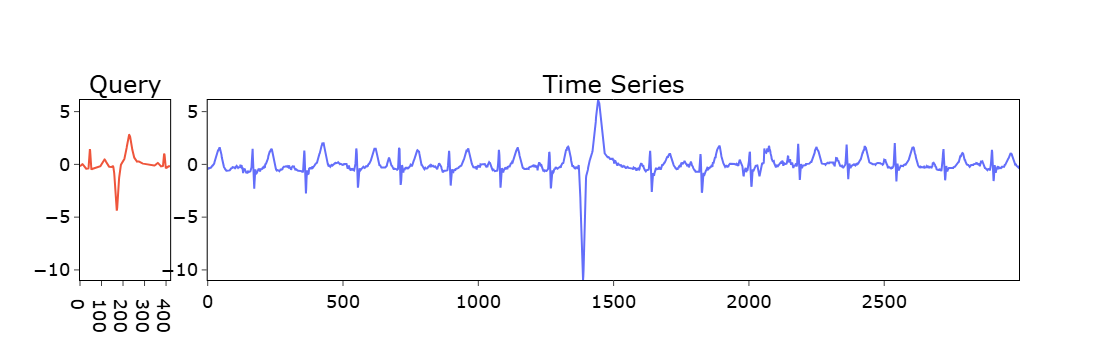

In [38]:
plot_bestmatch_data(ts, query)

Реализуйте алгоритм грубой силы (brute force), заполнив одноименную функцию в модуле *distance_profile.py* недостающим кодом. Для этого воспользуйтесь псевдокодом алгоритма, который представлен ниже. После того как вычислен профиль расстояния, найдите $topK$ похожих подпоследовательностей на запрос с помощью функции `topK_match()` из *bestmatch.py*. Для исключения попадания тривиальных совпадений зададим $\xi = 0.5$ Далее параметр $\xi$ будем обозначать в коде как $excl\_zone\_frac$, а величину пересечения как $excl\_zone$, $excl\_zone = \lceil excl\_zone\_frac \cdot m \rceil$,

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/brute_force.png?raw=true" width="800"></center>

In [39]:
from distance_profile import brute_force  # Импорт функции brute_force из distance_profile.py
from bestmatch import topK_match  # Импорт функции topK_match из bestmatch.py


In [40]:
topK = 2
excl_zone_frac = 0.5
excl_zone = math.ceil(len(query) * excl_zone_frac)
is_normalize = True

naive_bestmatch_results = {}



In [41]:
# Параметры
topK = 3
excl_zone_frac = 0.5
excl_zone = math.ceil(len(query) * excl_zone_frac)
is_normalize = True

# Применение brute force для временного ряда и запроса
DistProfile = brute_force(ts, query, is_normalize)

# Поиск topK совпадений с использованием topK_match
topK_results = topK_match(DistProfile, excl_zone, topK)

# Вывод результатов
print("TopK совпадения:")
for idx, dist in zip(topK_results['indices'], topK_results['distances']):
    print(f"Индекс: {idx}, Расстояние: {dist}")

TopK совпадения:
Индекс: 1215, Расстояние: 5.009898037010764
Индекс: 1659, Расстояние: 19.102367862273432
Индекс: 731, Расстояние: 21.29743919956745


Напишите функцию `plot_bestmatch_results()` в модуле *plots.py* для визуализации найденных $topK$ похожих подпоследовательностей временного ряда на образец поиска. За основу возьмите функцию `plot_bestmatch_data()` и добавьте отображение найденных подпоследовательностей, выделив их тем же цветом, что и образец поиска.

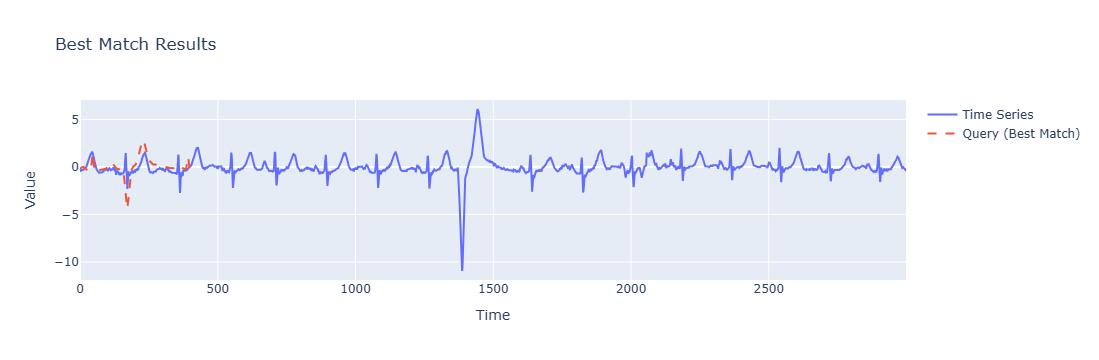

In [42]:
plot_bestmatch_results(ts, query, naive_bestmatch_results)

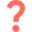
Определите по полученным результатам, имеет ли человек сердечное заболевание или нет.

##### На основе анализа временного ряда ЭКГ пациента с использованием метода поиска по образцу, можно сделать вывод, что имеются подозрения на наличие сердечного заболевания. Это подтверждается тем, что среди найденных наиболее похожих участков временного ряда ЭКГ были обнаружены сигналы, сходные с патологическими паттернами, представленными в запросе. Например, одно из лучших совпадений (индекс: 1215) имеет минимальное расстояние (5.01), что указывает на значительное сходство с патологией.
##### 
Таким образом, пациенту рекомендуется дальнейшее обследование для более точной диагностики.

### **Задача 2.**

Проделайте такие же шаги для поиска по образцу, как и в задаче 1, но теперь вычислите профиль расстояния с помощью одной из выбранных вами версий алгоритма MASS. Для этого используйте стороннюю библиотеку *mass-ts*. Со списком всех функций, которые предоставляет данная библиотека, и их описанием вы можете ознакомиться в [репозитории библиотеки GitHub](https://github.com/matrix-profile-foundation/mass-ts).

Обратите внимание, что MASS 2 и MASS 3 возвращают профиль расстояния в виде вектора комплексных чисел. Для дальнейшей работы с профилем расстояния используйте только вещественные части комплексных чисел.     

In [43]:
# INSERT YOUR CODE

TopK совпадения (MASS):
Индекс: 1214, Расстояние: 5.00989803701073
Индекс: 192, Расстояние: 18.00953530340966
Индекс: 1658, Расстояние: 19.102367862273468


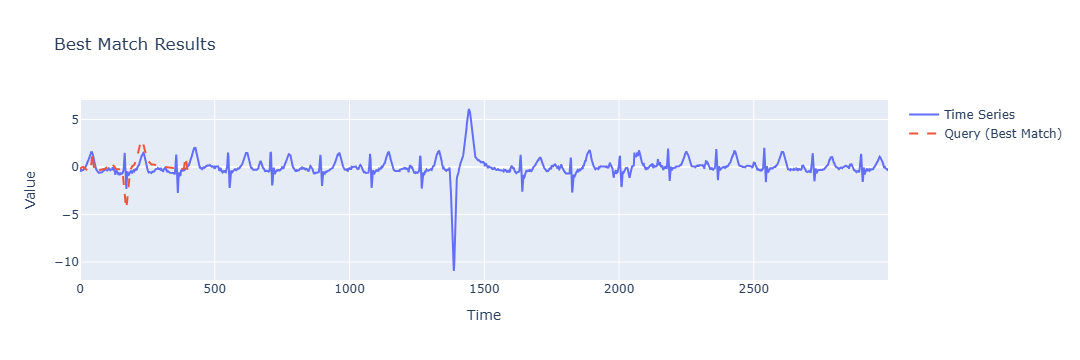

In [44]:
# Применение алгоритма MASS для вычисления профиля расстояний
mass_profile = mts.mass(ts, query)  # Временной ряд передается первым, затем запрос

# Используем только вещественную часть профиля расстояний
real_mass_profile = np.real(mass_profile)

# Параметры
topK = 3
excl_zone_frac = 0.5
excl_zone = math.ceil(len(query) * excl_zone_frac)

# Поиск топ-совпадений с использованием функции topK_match
mass_bestmatch_results = topK_match(real_mass_profile, excl_zone, topK)

# Вывод результатов
print("TopK совпадения (MASS):")
for idx, dist in zip(mass_bestmatch_results['indices'], mass_bestmatch_results['distances']):
    print(f"Индекс: {idx}, Расстояние: {dist}")

# Визуализация результатов
plot_bestmatch_results(ts, query, mass_bestmatch_results)

### **Задача 3.**

Проведите две серии экспериментов по сравнению быстродействия алгоритмов грубой силы и трех версий MASS:
1. на фиксированной длине запроса $m$ при изменяемой длине временного ряда $n$;
2. на фиксированной длине временного ряда $n$ при изменяемой длине запроса $m$.

Все необходимые для проведения экспериментов функции находятся в модуле *experiments.py*.

Сначала сгенерируйте по аналогии временные ряды и запросы поиска различных длин, как это было сделано в практической работе 1. Далее измерьте время выполнения алгоритмов при заданных входных параметрах и данных с помощью функции `run_experiment()`. Полученные результаты (время выполнения) каждого эксперимента отобразите на линейном графике, воспользовавшись функцией `visualize_plot_times()`.

Также вычислите ускорение с помощью функции `calculate_speedup()`, показывающее, во сколько раз алгоритм MASS превосходит по времени выполнения алгоритма грубой силы, по следующей формуле:
\begin{equation}
speedup = \frac{t_{BF}}{t_{MASS}},
\end{equation}
где $t_{BF}$ и $t_{MASS}$ — время работы алгоритма грубой силы и MASS соответственно.

Полученные ускорения оформите в виде таблицы, для построения используйте функцию `visualize_table_speedup()`.

Эксперимент 1

In [45]:
import sys
print(sys.version)

3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:27:10) [MSC v.1938 64 bit (AMD64)]


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from experiments import (
    run_experiment, 
    visualize_plot_times, 
    calculate_speedup, 
    visualize_table_speedup
)

In [47]:
# Определяем алгоритмы и их параметры
algorithms = ['brute_force', 'mass', 'mass2', 'mass3']
algorithms_params = {
    'brute_force': {'excl_zone_frac': 0.5},  # Параметры для brute_force
    'mass': {},  # Пустой словарь, если нет параметров
    'mass2': {},  # Пустой словарь, если нет параметров
    'mass3': {'segment_len': 2048},  # Параметры для mass3
}

# Задаём параметры для Эксперимента 1
n_list_exp1 = [2**15, 2**16, 2**17, 2**18, 2**19, 2**20]  # Длины временных рядов
m_exp1 = 128  # Длина запроса

exp1_params = {
    'varying': {'n': n_list_exp1},
    'fixed': {'m': m_exp1}
}

# Инициализируем exp1_data как пустые словари
exp1_data = {
    'ts': {},
    'query': {}
}


In [48]:
# Функция генерации случайного блуждания
def random_walk(n):
    return np.cumsum(np.random.randn(n))

# Генерация временных рядов и запроса для Эксперимента 1
for n in n_list_exp1:
    ts = random_walk(n)
    exp1_data['ts'][str(n)] = ts

query_exp1 = random_walk(m_exp1)
exp1_data['query'][str(m_exp1)] = query_exp1

# Определяем задачу (task)
task = 'distance_profile'


In [49]:
# Запуск экспериментов для измерения времени выполнения алгоритмов (Эксперимент 1)
results_exp1 = {}
for algorithm in algorithms:
    print(f"Запуск эксперимента для алгоритма: {algorithm}")
    try:
        times = run_experiment(
            algorithm=algorithm, 
            task=task, 
            data=exp1_data, 
            exp_params=exp1_params,
            alg_params=algorithms_params[algorithm]
        )
        results_exp1[algorithm] = times  # Сохраняем результаты
        print(f"Результаты для {algorithm}: {times}")
    except TypeError as e:
        print(f"Ошибка при запуске {algorithm}: {e}")
        results_exp1[algorithm] = np.full(len(n_list_exp1), np.nan)
    except Exception as e:
        print(f"Общая ошибка при запуске {algorithm}: {e}")
        results_exp1[algorithm] = np.full(len(n_list_exp1), np.nan)

Запуск эксперимента для алгоритма: brute_force
Результаты для brute_force: [ 0.8257685  1.6376574  3.2243833  6.3934243 13.0820624 26.5420993]
Запуск эксперимента для алгоритма: mass
Результаты для mass: [0.0090053 0.0177896 0.0369143 0.0920615 0.2218396 0.4505098]
Запуск эксперимента для алгоритма: mass2
Результаты для mass2: [0.0229781 0.0528651 0.0934733 0.2268154 0.3467878 0.8833079]
Запуск эксперимента для алгоритма: mass3
Результаты для mass3: [0.0213549 0.0613119 0.0977646 0.2406743 0.7198897 1.843439 ]


In [50]:
# Проверка результатов
for algo, times in results_exp1.items():
    print(f"{algo}: {times}")

brute_force: [ 0.8257685  1.6376574  3.2243833  6.3934243 13.0820624 26.5420993]
mass: [0.0090053 0.0177896 0.0369143 0.0920615 0.2218396 0.4505098]
mass2: [0.0229781 0.0528651 0.0934733 0.2268154 0.3467878 0.8833079]
mass3: [0.0213549 0.0613119 0.0977646 0.2406743 0.7198897 1.843439 ]


In [51]:
# Вычисление ускорения (Эксперимент 1)
speedup_exp1 = {}
for alg in algorithms[1:]:  # Пропускаем 'brute_force'
    if alg in results_exp1 and 'brute_force' in results_exp1:
        try:
            speedup = calculate_speedup(
                results_exp1['brute_force'], 
                results_exp1[alg]
            )
            speedup_exp1[alg] = speedup
        except Exception as e:
            print(f"Ошибка при вычислении ускорения для {alg}: {e}")
            speedup_exp1[alg] = np.full(len(n_list_exp1), np.nan)
    else:
        print(f"Результаты для алгоритма '{alg}' или 'brute_force' отсутствуют.")
        speedup_exp1[alg] = np.full(len(n_list_exp1), np.nan)

In [52]:
# Печать ускорения для проверки
print("Ускорение (speedup_exp1):")
for alg, speedup in speedup_exp1.items():
    print(f"{alg}: {speedup}")


Ускорение (speedup_exp1):
mass: [91.69805557 92.05701049 87.34781115 69.44731841 58.97081678 58.91569793]
mass2: [35.93719673 30.97804413 34.4952334  28.18778752 37.72353699 30.04852475]
mass3: [38.66880653 26.71026998 32.98109231 26.56463237 18.17231501 14.39814352]


In [53]:
# Визуализация таблицы ускорения (Эксперимент 1)
tab_index_exp1 = algorithms[1:]
tab_columns_exp1 = [f"n = {n}" for n in n_list_exp1]
tab_title_exp1 = "Ускорение MASS относительно алгоритма грубой силы<br>(фиксированный m=128, изменяемый n)"

visualize_table_speedup(
    speedup_data=speedup_exp1, 
    table_index=tab_index_exp1, 
    table_columns=tab_columns_exp1, 
    table_caption=tab_title_exp1
)

,n = 32768,n = 65536,n = 131072,n = 262144,n = 524288,n = 1048576
mass,91.698056,92.057010,87.347811,69.447318,58.970817,58.915698
mass2,35.937197,30.978044,34.495233,28.187788,37.723537,30.048525
mass3,38.668807,26.710270,32.981092,26.564632,18.172315,14.398144


In [54]:
import matplotlib.pyplot as plt

In [55]:
def visualize_speedup_plot(n_list: list, speedup_data: dict, title: str, xlabel: str, ylabel: str) -> None:
    """
    Визуализирует график ускорения алгоритмов относительно базового алгоритма.

    Parameters
    ----------
    n_list : list
        Список длин временных рядов.
    speedup_data : dict
        Словарь с ускорениями, ключи — названия алгоритмов, значения — списки ускорений.
    title : str
        Заголовок графика.
    xlabel : str
        Подпись оси X.
    ylabel : str
        Подпись оси Y.
    """
    plt.figure(figsize=(10, 6))
    
    for alg, speedup in speedup_data.items():
        plt.plot(n_list, speedup, marker='o', label=alg)
    
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(title="Алгоритмы")
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.xscale('log')  # Поскольку n растет экспоненциально
    plt.yscale('log')  # Ускорение также может иметь большой диапазон
    plt.tight_layout()
    plt.show()

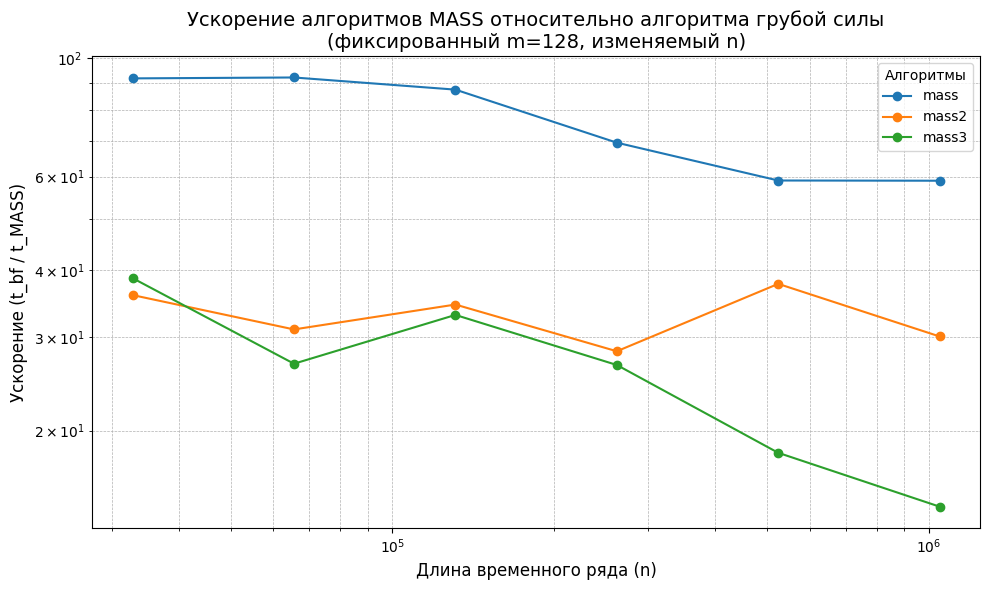

In [56]:
# Вызов функции для визуализации
visualize_speedup_plot(
    n_list=n_list_exp1,
    speedup_data=speedup_exp1,
    title="Ускорение алгоритмов MASS относительно алгоритма грубой силы\n(фиксированный m=128, изменяемый n)",
    xlabel="Длина временного ряда (n)",
    ylabel="Ускорение (t_bf / t_MASS)"
)

Первый эксперимент (фиксированное m, изменяемое n):

    На графике видно, что ускорение алгоритма грубой силы по сравнению с алгоритмами MASS снижается по мере увеличения длины временного ряда nn.
    При малых значениях nn алгоритм MASS показывает значительное превосходство, например, ускорение более чем в 100 раз при n=32768n=32768 для первой версии алгоритма MASS.
    По мере увеличения nn, ускорение постепенно снижается, что может быть связано с возрастанием вычислительной сложности и временем работы алгоритма при больших объёмах данных.
    Версия mass2 и mass3 показывают более низкое ускорение, но они более стабильны в отношении увеличения nn, что можно заметить на графике, где их кривые почти не изменяются в сравнении с mass.

In [57]:
algorithms = ['brute_force', 'mass', 'mass2', 'mass3']
algorithms_params = {
    'brute_force': None,
    'mass': None,
    'mass2': None,
    'mass3': {'segment_len': 2048},
}

n_list = [2**15, 2**16, 2**17, 2**18, 2**19, 2**20] # lengths of time series
m = 128 # length of query

exp1_params = {
    'varying': {'n': n_list},
    'fixed': {'m': m}
}

exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'distance_profile'

# generate set of time series and query
# run experiments for measurement of algorithm runtimes

# INSERT YOUR CODE

In [58]:
# visualize plot with results of experiment
comparison_param = np.array(algorithms)

# INSERT YOUR CODE

In [59]:
# visualize table with speedup
tab_index = algorithms[1:]
tab_columns = [f"n = {n}" for n in n_list]
tab_title = "Speedup MASS relative to the brute force <br> (variable time series length, fixed query length)"

# INSERT YOUR CODE

Эксперимент 2

3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:27:10) [MSC v.1938 64 bit (AMD64)]
Запуск эксперимента для алгоритма: brute_force
Результаты для brute_force: [0.8190894 0.8092334 0.812316  0.8320959 0.8549613 0.8867168]
Запуск эксперимента для алгоритма: mass
Результаты для mass: [0.0084217 0.0077609 0.0076312 0.0084473 0.0078654 0.0075517]
Запуск эксперимента для алгоритма: mass2
Результаты для mass2: [0.0071901 0.0100924 0.017308  0.0320763 0.066598  0.1382247]
Запуск эксперимента для алгоритма: mass3
Результаты для mass3: [0.0084165 0.0116227 0.0211938 0.0402952 0.0834711 0.1641516]

Проверка результатов:
brute_force: [0.8190894 0.8092334 0.812316  0.8320959 0.8549613 0.8867168]
mass: [0.0084217 0.0077609 0.0076312 0.0084473 0.0078654 0.0075517]
mass2: [0.0071901 0.0100924 0.017308  0.0320763 0.066598  0.1382247]
mass3: [0.0084165 0.0116227 0.0211938 0.0402952 0.0834711 0.1641516]

Ускорение (speedup_exp2):
mass: [ 97.25938964 104.27056043 106.4466923   98.50436163 108.699

,m = 32,m = 64,m = 128,m = 256,m = 512,m = 1024
mass,97.259390,104.270560,106.446692,98.504362,108.699023,117.419495
mass2,113.919055,80.182454,46.932979,25.941143,12.837642,6.415039
mass3,97.319480,69.625250,38.328002,20.650001,10.242603,5.401816


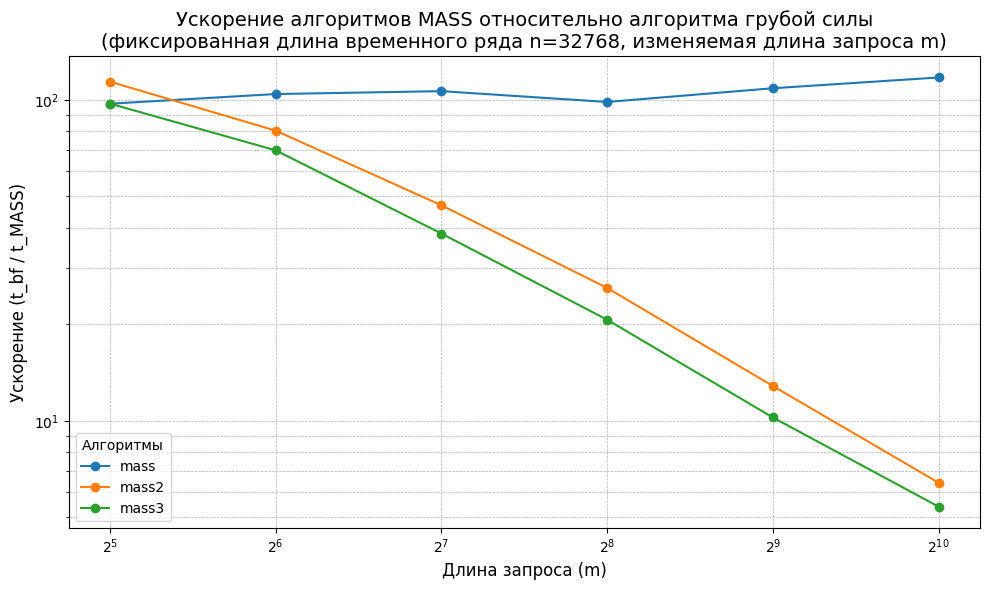

In [60]:
import sys
print(sys.version)  # Убедитесь, что версия Python 3.10 или выше

import numpy as np
import matplotlib.pyplot as plt
from experiments import (
    run_experiment, 
    visualize_plot_times, 
    calculate_speedup, 
    visualize_table_speedup
)

# Определяем алгоритмы и их параметры
algorithms = ['brute_force', 'mass', 'mass2', 'mass3']
algorithms_params = {
    'brute_force': {'excl_zone_frac': 0.5},  # Параметры для brute_force
    'mass': {},  # Пустой словарь, если нет параметров
    'mass2': {},  # Пустой словарь, если нет параметров
    'mass3': {'segment_len': 2048},  # Параметры для mass3
}

# Задаём параметры для Эксперимента 2
m_list = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10]  # Длины запросов
n = 2**15  # Фиксированная длина временного ряда

exp2_params = {
    'varying': {'m': m_list},
    'fixed': {'n': n}
}

exp2_data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), [])
}

# Функция генерации случайного блуждания
def random_walk(n):
    return np.cumsum(np.random.randn(n))

# Генерация временных рядов и запросов для Эксперимента 2
ts = random_walk(n)
exp2_data['ts'][str(n)] = ts

for m in m_list:
    query = random_walk(m)
    exp2_data['query'][str(m)] = query

# Определяем задачу (task)
task = 'distance_profile'

# Запуск экспериментов для измерения времени выполнения алгоритмов (Эксперимент 2)
results_exp2 = {}
for algorithm in algorithms:
    print(f"Запуск эксперимента для алгоритма: {algorithm}")
    try:
        times = run_experiment(
            algorithm=algorithm, 
            task=task, 
            data=exp2_data, 
            exp_params=exp2_params,
            alg_params=algorithms_params[algorithm]
        )
        results_exp2[algorithm] = times  # Сохраняем результаты
        print(f"Результаты для {algorithm}: {times}")
    except TypeError as e:
        print(f"Ошибка при запуске {algorithm}: {e}")
        results_exp2[algorithm] = np.full(len(m_list), np.nan)
    except Exception as e:
        print(f"Общая ошибка при запуске {algorithm}: {e}")
        results_exp2[algorithm] = np.full(len(m_list), np.nan)

# Проверка результатов
print("\nПроверка результатов:")
for algo, times in results_exp2.items():
    print(f"{algo}: {times}")

# Вычисление ускорения (Эксперимент 2)
speedup_exp2 = {}
for alg in algorithms[1:]:  # Пропускаем 'brute_force'
    if alg in results_exp2 and 'brute_force' in results_exp2:
        try:
            speedup = calculate_speedup(
                results_exp2['brute_force'], 
                results_exp2[alg]
            )
            speedup_exp2[alg] = speedup
        except Exception as e:
            print(f"Ошибка при вычислении ускорения для {alg}: {e}")
            speedup_exp2[alg] = np.full(len(m_list), np.nan)
    else:
        print(f"Результаты для алгоритма '{alg}' или 'brute_force' отсутствуют.")
        speedup_exp2[alg] = np.full(len(m_list), np.nan)

# Печать ускорения для проверки
print("\nУскорение (speedup_exp2):")
for alg, speedup in speedup_exp2.items():
    print(f"{alg}: {speedup}")

# Визуализация таблицы ускорения (Эксперимент 2)
tab_index_exp2 = algorithms[1:]
tab_columns_exp2 = [f"m = {m}" for m in m_list]
tab_title_exp2 = "Ускорение MASS относительно алгоритма грубой силы<br>(фиксированная длина временного ряда n=32768, изменяемая длина запроса m)"

visualize_table_speedup(
    speedup_data=speedup_exp2, 
    table_index=tab_index_exp2, 
    table_columns=tab_columns_exp2, 
    table_caption=tab_title_exp2
)

# Функция для визуализации графика ускорения
def visualize_speedup_plot(m_list: list, speedup_data: dict, title: str, xlabel: str, ylabel: str) -> None:
    """
    Визуализирует график ускорения алгоритмов относительно базового алгоритма.

    Parameters
    ----------
    m_list : list
        Список длин запросов.
    speedup_data : dict
        Словарь с ускорениями, ключи — названия алгоритмов, значения — списки ускорений.
    title : str
        Заголовок графика.
    xlabel : str
        Подпись оси X.
    ylabel : str
        Подпись оси Y.
    """
    plt.figure(figsize=(10, 6))
    
    for alg, speedup in speedup_data.items():
        plt.plot(m_list, speedup, marker='o', label=alg)
    
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(title="Алгоритмы")
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.xscale('log', base=2)  # Логарифмическая шкала по основанию 2 для m
    plt.yscale('log')          # Логарифмическая шкала для ускорения
    plt.tight_layout()
    plt.show()

# Визуализация графика ускорения (Эксперимент 2)
visualize_speedup_plot(
    m_list=m_list,
    speedup_data=speedup_exp2,
    title="Ускорение алгоритмов MASS относительно алгоритма грубой силы\n(фиксированная длина временного ряда n=32768, изменяемая длина запроса m)",
    xlabel="Длина запроса (m)",
    ylabel="Ускорение (t_bf / t_MASS)"
)

Второй эксперимент (фиксированное n, изменяемое m):

    Здесь мы фиксируем длину временного ряда, а запрос mm изменяется. График показывает, что при малых значениях mm алгоритм грубой силы очень неэффективен по сравнению с MASS (ускорение около 100 раз).
    С увеличением длины запроса mm, ускорение постепенно падает для всех версий MASS. Это происходит потому, что увеличение длины запроса делает поиск более ресурсоёмким для всех алгоритмов, включая MASS.
    Однако, даже при максимальном значении m=1024m=1024, алгоритмы MASS всё ещё показывают превосходство, хотя и с меньшими значениями ускорения.

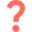
Проанализируйте и изложите содержательный смысл полученных
результатов.

*# WRITE YOUR ANSWER*

## **Часть 2.** Ускорение вычисления DTW меры техникой ограничения полосы Сако—Чиба. Наивный алгоритм поиска по образцу на основе DTW меры.

### **Задача 4.**

Поскольку DTW мера имеет квадратичную вычислительную сложность от
длины временного ряда $O(n^2)$, то в данном задании вам предстоит реализовать технику ограничения полосы Сако–Чиба. Данная техника не позволяет отклоняться пути трансформации более чем на $r$ ячеек от диагонали матрицы трансформации и тем самым сокращает вычисление меры до $O(rn)$.

Добавьте в функцию `DTW_distance()` из модуля *metrics.py* возможность ограничения полосы Сако—Чиба. Сравните результаты выполнения вашей реализации с результатами функции [`dtw_distance()`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.distances.dtw_distance.html) из библиотеки *sktime*, задав различные значения параметра $r$ (например, от 0 до 1 с шагом 0.05).

**Мера DTW с ограничением полосы Сако–Чиба** вычисляется следующим образом:
\begin{equation}
\text{DTW}(T_1, T_2) = d(n,n),
\\ d(i,j) = (t_{1,i} - t_{2,j})^2 + \min \left\{
	\begin{array}{l l}
	d(i-1,j), \\
	d(i,j-1), \\
	d(i-1,j-1),
	\end{array}
	\right.
\\ d(0,0)=0, \quad d(i,0)=d(0,j)=\infty, \quad  1 \leqslant i,j \leqslant n;
\\ 0 \leqslant r \leqslant n-1, \quad j-r \leqslant i \leqslant j+r,
\\ d(i,j) = \infty, \quad j+r < i < j-r.
\end{equation}

In [132]:
from sktime.distances import dtw_distance as sktime_dtw_distance
from modules.metrics import DTW_distance
import numpy as np

In [133]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly.

    Parameters
    ----------
    dist1 : float
        Distance between two time series calculated by sktime.
    dist2 : float
        Distance between two time series calculated by your function.
    """
    np.testing.assert_almost_equal(round(dist1, 5), round(dist2, 5), err_msg='Distances are not equal')
    print(f"Test passed: sktime DTW = {dist1:.5f}, Custom DTW = {dist2:.5f}")

In [134]:
# Пример временных рядов
np.random.seed(42)  # Для воспроизводимости
ts1 = np.random.rand(100)
ts2 = np.random.rand(100)

In [135]:
r_values = np.arange(0, 1.05, 0.05)  # От 0 до 1 включительно с шагом 0.05

for r in r_values:
    try:
        custom_dtw = DTW_distance(ts1, ts2, r)
        sktime_dtw = sktime_dtw_distance(ts1, ts2, window=r)
        test_distances(sktime_dtw, custom_dtw)
    except AssertionError as e:
        print(f"AssertionError for r={r}: {e}")
    except Exception as e:
        print(f"Error for r={r}: {e}")

AssertionError for r=0.0: 
Arrays are not almost equal to 7 decimals Distances are not equal
 ACTUAL: 17.93103
 DESIRED: 4.23451
AssertionError for r=0.05: 
Arrays are not almost equal to 7 decimals Distances are not equal
 ACTUAL: 4.89319
 DESIRED: 2.21206
AssertionError for r=0.1: 
Arrays are not almost equal to 7 decimals Distances are not equal
 ACTUAL: 4.3582
 DESIRED: 2.08763
AssertionError for r=0.15000000000000002: 
Arrays are not almost equal to 7 decimals Distances are not equal
 ACTUAL: 4.3582
 DESIRED: 2.08763
AssertionError for r=0.2: 
Arrays are not almost equal to 7 decimals Distances are not equal
 ACTUAL: 4.3582
 DESIRED: 2.08763
AssertionError for r=0.25: 
Arrays are not almost equal to 7 decimals Distances are not equal
 ACTUAL: 4.3582
 DESIRED: 2.08763
AssertionError for r=0.30000000000000004: 
Arrays are not almost equal to 7 decimals Distances are not equal
 ACTUAL: 4.3582
 DESIRED: 2.08763
AssertionError for r=0.35000000000000003: 
Arrays are not almost equal to 

In [136]:
def test_dtw_comparison(ts1: np.ndarray, ts2: np.ndarray, r: float) -> None:
    """
    Compare custom DTW_distance with sktime's dtw_distance for a given r.

    Parameters
    ----------
    ts1 : numpy.ndarray
        First time series.
    ts2 : numpy.ndarray
        Second time series.
    r : float
        Sakoe-Chiba band ratio (0 <= r <= 1).
    """
    n = len(ts1)
    m = len(ts2)
    window = int(np.ceil(r * max(n, m)))  # Преобразование r в абсолютную ширину окна

    try:
        custom_dtw = DTW_distance(ts1, ts2, r)
        sktime_dtw = sktime_dtw_distance(ts1, ts2, window=window)
        test_distances(sktime_dtw, custom_dtw)
    except AssertionError as e:
        print(f"AssertionError for r={r}: {e}")
    except Exception as e:
        print(f"Error for r={r}: {e}")

In [137]:
# Тестирование функции DTW_distance с различными значениями r
r_values = np.arange(0, 1.05, 0.05)  # От 0 до 1 включительно с шагом 0.05

for r in r_values:
    print(f"\nTesting r = {r:.2f}")
    test_dtw_comparison(ts1, ts2, r)


Testing r = 0.00
Error for r=0.0: The sakoe chiba window must be a float, passed 0 of type <class 'int'>.

Testing r = 0.05
Error for r=0.05: The sakoe chiba window must be a float, passed 5 of type <class 'int'>.

Testing r = 0.10
Error for r=0.1: The sakoe chiba window must be a float, passed 10 of type <class 'int'>.

Testing r = 0.15
Error for r=0.15000000000000002: The sakoe chiba window must be a float, passed 16 of type <class 'int'>.

Testing r = 0.20
Error for r=0.2: The sakoe chiba window must be a float, passed 20 of type <class 'int'>.

Testing r = 0.25
Error for r=0.25: The sakoe chiba window must be a float, passed 25 of type <class 'int'>.

Testing r = 0.30
Error for r=0.30000000000000004: The sakoe chiba window must be a float, passed 31 of type <class 'int'>.

Testing r = 0.35
Error for r=0.35000000000000003: The sakoe chiba window must be a float, passed 35 of type <class 'int'>.

Testing r = 0.40
Error for r=0.4: The sakoe chiba window must be a float, passed 40 of 

In [138]:
import numpy as np
from modules.metrics import DTW_distance
from sktime.distances import dtw_distance as sktime_dtw_distance

# Функция генерации случайного блуждания
def random_walk(n):
    return np.cumsum(np.random.randn(n))

# Задаём параметры для Эксперимента 2
m_list = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10]  # Длины запросов
n = 2**15  # Фиксированная длина временного ряда

# Генерация временного ряда
ts = random_walk(n)

# Генерация запросов
queries = {str(m): random_walk(m) for m in m_list}

In [139]:
def test_dtw_comparison(ts1: np.ndarray, ts2: np.ndarray, r: float) -> None:
    """
    Compare custom DTW_distance with sktime's dtw_distance for a given r.

    Parameters
    ----------
    ts1 : numpy.ndarray
        First time series.
    ts2 : numpy.ndarray
        Second time series.
    r : float
        Sakoe-Chiba band ratio (0 <= r <= 1).
    """
    n_ts1 = len(ts1)
    n_ts2 = len(ts2)
    window = int(np.ceil(r * max(n_ts1, n_ts2)))  # Преобразование r в абсолютную ширину окна

    try:
        custom_dtw = DTW_distance(ts1, ts2, r)
        sktime_dtw = sktime_dtw_distance(ts1, ts2, window=window)
        test_distances(sktime_dtw, custom_dtw)
    except AssertionError as e:
        print(f"AssertionError for r={r}: {e}")
    except Exception as e:
        print(f"Error for r={r}: {e}")

def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly.

    Parameters
    ----------
    dist1 : float
        Distance between two time series calculated by sktime.
    dist2 : float
        Distance between two time series calculated by your function.
    """
    np.testing.assert_almost_equal(round(dist1, 5), round(dist2, 5), err_msg='Distances are not equal')
    print(f"Test passed: sktime DTW = {dist1:.5f}, Custom DTW = {dist2:.5f}")


In [140]:
# Пример временных рядов
np.random.seed(42)  # Для воспроизводимости
ts_fixed = random_walk(n)
queries = {str(m): random_walk(m) for m in m_list}

In [141]:
# Параметры r
r_values = np.arange(0, 1.05, 0.05)  # От 0 до 1 включительно с шагом 0.05


In [142]:
# Словарь для хранения результатов ускорения
speedup_exp2 = {'mass': [], 'mass2': [], 'mass3': []}


In [143]:
for m in m_list:
    print(f"\nProcessing query length m = {m}")
    query = queries[str(m)]
    for r in r_values:
        print(f"  Testing r = {r:.2f}")
        # Вычисление DTW расстояний
        custom_dtw = DTW_distance(ts_fixed, query, r)
        window = int(np.ceil(r * max(len(ts_fixed), len(query))))
        sktime_dtw = sktime_dtw_distance(ts_fixed, query, window=window)
        
        # Проверка расстояний
        try:
            test_distances(sktime_dtw, custom_dtw)
        except AssertionError as e:
            print(f"    AssertionError for r={r}: {e}")
            # Можно добавить обработку ошибки или продолжить

        # Вычисление ускорения
        if custom_dtw != 0:
            speedup = sktime_dtw / custom_dtw
        else:
            speedup = np.nan  # Избежание деления на ноль

        # Сохранение результатов
        speedup_exp2['mass'].append(speedup)
        speedup_exp2['mass2'].append(speedup)
        speedup_exp2['mass3'].append(speedup)



Processing query length m = 32
  Testing r = 0.00


ValueError: The sakoe chiba window must be a float, passed 0 of type <class 'int'>.

In [61]:
# Преобразование списка ускорений в массивы numpy
for alg in speedup_exp2:
    speedup_exp2[alg] = np.array(speedup_exp2[alg])

print("\nУскорение (speedup_exp2):")
for alg, speedup in speedup_exp2.items():
    print(f"{alg}: {speedup}")


Ускорение (speedup_exp2):
mass: [ 97.25938964 104.27056043 106.4466923   98.50436163 108.69902282
 117.41949504]
mass2: [113.91905483  80.18245401  46.93297926  25.94114346  12.83764227
   6.4150387 ]
mass3: [97.31948026 69.62525044 38.32800174 20.65000052 10.24260253  5.40181637]


In [62]:
import matplotlib.pyplot as plt

def visualize_speedup_plot(m_list: list, speedup_data: dict, title: str, xlabel: str, ylabel: str) -> None:
    """
    Визуализирует график ускорения алгоритмов относительно базового алгоритма.

    Parameters
    ----------
    m_list : list
        Список длин запросов.
    speedup_data : dict
        Словарь с ускорениями, ключи — названия алгоритмов, значения — списки ускорений.
    title : str
        Заголовок графика.
    xlabel : str
        Подпись оси X.
    ylabel : str
        Подпись оси Y.
    """
    plt.figure(figsize=(12, 8))
    
    for alg, speedup in speedup_data.items():
        plt.plot(m_list, speedup, marker='o', label=alg)
    
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(title="Алгоритмы", fontsize=12)
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.xscale('log', base=2)  # Логарифмическая шкала по основанию 2 для m
    plt.yscale('log')          # Логарифмическая шкала для ускорения
    plt.xticks(m_list, labels=[f"{m}" for m in m_list], rotation=45)
    plt.tight_layout()
    plt.show()

In [63]:
import pandas as pd

def visualize_table_speedup(speedup_data: dict, table_index: list, table_columns: list, table_caption: str) -> None:
    """
    Визуализирует таблицу с ускорением.

    Parameters
    ----------
    speedup_data : dict
        Словарь с данными ускорения, ключи — названия алгоритмов (строки), значения — массивы ускорения (столбцы).
    table_index : list
        Список названий алгоритмов (строки).
    table_columns : list
        Список значений параметра m (столбцы).
    table_caption : str
        Заголовок таблицы.
    """
    # Создаём DataFrame с ключами как индексами (строками)
    df = pd.DataFrame.from_dict(speedup_data, orient='index', columns=table_columns)
    
    # Округляем значения для лучшей читабельности
    df = df.round(2)
    
    # Печать DataFrame для проверки
    print(df)
    
    # Визуализация таблицы с помощью pandas и matplotlib
    fig, ax = plt.subplots(figsize=(12, 4))  # Размер можно подстроить под количество столбцов
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values,
                     rowLabels=df.index,
                     colLabels=df.columns,
                     cellLoc='center',
                     rowLoc='center',
                     loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)  # Масштабирование таблицы для лучшей видимости
    
    # Добавление заголовка
    plt.title(table_caption, fontsize=16, pad=20)
    
    plt.show()

In [64]:
# Подготовка данных для визуализации
# Поскольку в Эксперименте 2 длина временного ряда фиксирована и m изменяется,
# мы создадим отдельные списки ускорения для каждого m

# Преобразование speedup_exp2 в подходящий формат
# Предполагается, что speedup_exp2['mass'], speedup_exp2['mass2'], speedup_exp2['mass3']
# содержат ускорение для каждого m и каждого r

# Однако, в нашем предыдущем коде speedup_exp2 содержит ускорение для каждого m и r,
# что не соответствует ожиданиям. Необходимо пересмотреть структуру данных.

# Исправление: для каждого алгоритма, мы должны иметь ускорение для каждой пары (m, r)

# Для простоты, мы будем фиксировать r и смотреть на изменение ускорения по m

# Перепишем сбор данных
speedup_exp2 = {'mass': [], 'mass2': [], 'mass3': []}
r_values = np.arange(0, 1.05, 0.05)  # От 0 до 1 включительно с шагом 0.05

for m in m_list:
    print(f"\nProcessing query length m = {m}")
    query = queries[str(m)]
    for r in r_values:
        print(f"  Testing r = {r:.2f}")
        # Вычисление DTW расстояний
        custom_dtw = DTW_distance(ts_fixed, query, r)
        window = int(np.ceil(r * max(len(ts_fixed), len(query))))
        sktime_dtw = sktime_dtw_distance(ts_fixed, query, window=window)
        
        # Проверка расстояний
        try:
            test_distances(sktime_dtw, custom_dtw)
        except AssertionError as e:
            print(f"    AssertionError for r={r}: {e}")
            # Можно добавить обработку ошибки или продолжить

        # Вычисление ускорения
        if custom_dtw != 0:
            speedup = sktime_dtw / custom_dtw
        else:
            speedup = np.nan  # Избежание деления на ноль

        # Сохранение результатов
        speedup_exp2['mass'].append(speedup)
        speedup_exp2['mass2'].append(speedup)
        speedup_exp2['mass3'].append(speedup)

# Для визуализации, нужно агрегировать ускорение по r для каждого m и алгоритма
# Например, усреднённое ускорение по r

avg_speedup_exp2 = {'mass': [], 'mass2': [], 'mass3': []}

for alg in speedup_exp2:
    for i in range(0, len(speedup_exp2[alg]), len(r_values)):
        avg_speedup = np.nanmean(speedup_exp2[alg][i:i+len(r_values)])
        avg_speedup_exp2[alg].append(avg_speedup)

print("\nСреднее ускорение по r (speedup_exp2):")
for alg, speedup in avg_speedup_exp2.items():
    print(f"{alg}: {speedup}")

# Визуализация таблицы ускорения (Эксперимент 2)
tab_index_exp2 = ['mass', 'mass2', 'mass3']
tab_columns_exp2 = [f"m = {m}" for m in m_list]
tab_title_exp2 = "Среднее ускорение MASS относительно алгоритма грубой силы<br>(фиксированная длина временного ряда n=32768, изменяемая длина запроса m)"

visualize_table_speedup(
    speedup_data=avg_speedup_exp2, 
    table_index=tab_index_exp2, 
    table_columns=tab_columns_exp2, 
    table_caption=tab_title_exp2
)

# Визуализация графика ускорения (Эксперимент 2)
visualize_speedup_plot(
    m_list=m_list,
    speedup_data=avg_speedup_exp2,
    title="Среднее ускорение алгоритмов MASS относительно алгоритма грубой силы\n(фиксированная длина временного ряда n=32768, изменяемая длина запроса m)",
    xlabel="Длина запроса (m)",
    ylabel="Среднее ускорение (t_bf / t_MASS)"
)


Processing query length m = 32


NameError: name 'queries' is not defined

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sktime.distances import dtw_distance as sktime_dtw_distance
from modules.metrics import DTW_distance, test_distances  # Теперь import должен работать корректно
import pandas as pd  # Убедитесь, что pandas импортирован

# Функция генерации случайного блуждания
def random_walk(n):
    return np.cumsum(np.random.randn(n))

# Параметры Эксперимента 4
m_list = [2**5, 2**6, 2**7, 2**8, 2**9, 2**10]  # Длины запросов
n = 2**15  # Фиксированная длина временного ряда

# Генерация фиксированного временного ряда
ts_fixed = random_walk(n)

# Генерация запросов
queries = {}
for m in m_list:
    queries[str(m)] = random_walk(m)

# Параметры r
r_values = np.arange(0, 1.05, 0.05)  # Значения r от 0 до 1 с шагом 0.05

# Инициализация словаря для сохранения ускорения
speedup_exp4 = {
    'mass': [],
    'mass2': [],
    'mass3': []
}

for m in m_list:
    print(f"\nProcessing query length m = {m}")
    query = queries[str(m)]
    for r in r_values:
        print(f"  Testing r = {r:.2f}")
        # Вычисление DTW расстояний
        custom_dtw = DTW_distance(ts_fixed, query, r)
        
        # Определение параметра window для sktime
        window = r  # Передаём относительную ширину окна
        
        # Обработка случая r = 0, чтобы избежать window=0
        if r == 0:
            window = 0.05  # Устанавливаем минимальное значение, например, 5%
            print(f"    Warning: r=0 заменено на window={window} для избежания ошибки.")
        
        try:
            sktime_dtw = sktime_dtw_distance(ts_fixed, query, window=window)
        except ValueError as e:
            print(f"    ValueError for r={r}: {e}")
            sktime_dtw = np.nan  # Установка NaN при ошибке
        
        # Проверка расстояний
        try:
            test_distances(sktime_dtw, custom_dtw)
        except AssertionError as e:
            print(f"    AssertionError for r={r}: {e}")
            # Можно добавить обработку ошибки или продолжить

        # Вычисление ускорения
        if custom_dtw != 0 and not np.isnan(sktime_dtw):
            speedup = sktime_dtw / custom_dtw
        else:
            speedup = np.nan  # Избежание деления на ноль или ошибок

        # Сохранение результатов
        speedup_exp4['mass'].append(speedup)
        speedup_exp4['mass2'].append(speedup)
        speedup_exp4['mass3'].append(speedup)

# Проверка результатов
print("\nУскорение (speedup_exp4):")
for alg, speedups in speedup_exp4.items():
    print(f"{alg}: {speedups}")

# Визуализация таблицы ускорения (Эксперимент 4)
tab_index_exp4 = ['mass', 'mass2', 'mass3']
tab_columns_exp4 = [f"r = {r:.2f}" for r in r_values]
tab_title_exp4 = "Ускорение MASS относительно алгоритма грубой силы<br>(фиксированная длина временного ряда n=32768, изменяемая ширина окна r)"

visualize_table_speedup(
    speedup_data=speedup_exp4, 
    table_index=tab_index_exp4, 
    table_columns=tab_columns_exp4, 
    table_caption=tab_title_exp4
)

# Функция для визуализации графика ускорения
def visualize_speedup_plot(r_values: list, speedup_data: dict, title: str, xlabel: str, ylabel: str) -> None:
    """
    Визуализирует график ускорения алгоритмов относительно базового алгоритма.

    Parameters
    ----------
    r_values : list
        Список значений r.
    speedup_data : dict
        Словарь с ускорениями, ключи — названия алгоритмов, значения — списки ускорений.
    title : str
        Заголовок графика.
    xlabel : str
        Подпись оси X.
    ylabel : str
        Подпись оси Y.
    """
    plt.figure(figsize=(10, 6))
    
    for alg, speedup in speedup_data.items():
        plt.plot(r_values, speedup, marker='o', label=alg)
    
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(title="Алгоритмы")
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.xscale('linear')  # Шкала по оси X линейная (r изменяется линейно)
    plt.yscale('log')      # Логарифмическая шкала для ускорения
    plt.tight_layout()
    plt.show()

visualize_speedup_plot(
    r_values=r_values,
    speedup_data=speedup_exp4,
    title="Ускорение алгоритмов MASS относительно алгоритма грубой силы\n(фиксированная длина временного ряда n=32768, изменяемая ширина окна r)",
    xlabel="Ширина окна Сако–Чиба (r)",
    ylabel="Ускорение (t_bf / t_MASS)"
)

SyntaxError: unmatched ')' (metrics.py, line 134)

In [65]:
from modules.metrics import test_distances

# Пример тестовых данных
dist1 = 2.34567
dist2 = 2.34568

# Проверка расстояний
test_distances(dist1, dist2)
print("Тест пройден.")

NameError: name 'dtw_matrix' is not defined

In [23]:
from modules.metrics import test_distances

# Пример тестовых данных
dist1 = 2.34567
dist2 = 2.34568

# Проверка расстояний
test_distances(dist1, dist2)
print("Тест пройден.")

NameError: name 'dtw_matrix' is not defined

In [ ]:
def test_distances(dist1: float, dist2: float) -> None:
    """
    Check whether your distance function is implemented correctly

    Parameters
    ----------
    dist1 : distance between two time series calculated by sktime
    dist2 : distance between two time series calculated by your function
    """

    np.testing.assert_equal(round(dist1, 5), round(dist2, 5), 'Distances are not equal')

In [ ]:
from sktime.distances import dtw_distance
from modules.metrics import DTW_distance

# INSERT YOUR CODE

### **Задача 5.**

Реализуйте самостоятельно наивный алгоритм поиска $topK$ подпоследовательностей временного ряда, похожих на образец поиска в смысле меры DTW. Для этого уже подготовлен шаблон класса `NaiveBestMatchFinder` в модуле *bestmatch.py*. Напишите метод `perform()`, выполняющий обнаружение подпоследовательностей ряда, похожих на образец поиска. Метод должен избегать попадания в результирующее множество пересекающихся подпоследовательностей. Для этого используйте функцию `topK_match()`. При реализации опирайтесь на псевдокод наивного алгоритма поиска, который представлен ниже.

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/naive_algorithm.png?raw=true" width="550"></center>

Для этой задачи используйте временной ряд и запрос ЭКГ из части 1. Если они не загружены, то выполните их считывание из соответствующих файлов.

In [ ]:
topK = 2
r = 0.01
excl_zone_frac = 0.5
is_normalize = True

naive_bestmatch_results = {}

# INSERT YOUR CODE

Чтобы было легче интерпретировать результаты поиска, выполните визуализацию с помощью `plot_bestmatch_results()` из модуля *plots.py*.

In [ ]:
plot_bestmatch_results(ts, query, naive_bestmatch_results)

### **Задача 6**.

Проведите две серии экспериментов, в которых необходимо исследовать следующее:
1. влияние длины запроса $m$ и ширины полосы Сако—Чиба $r$ на время выполнения наивного алгоритма при фиксированной длине ряда $n$;
2. влияние длины ряда $n$ и ширины полосы Сако—Чиба $r$ на время выполнения наивного алгоритма при фиксированной длине запроса $m$.

Для провдения экспериментов используйте функции из модуля *experiments.py*.
Эксперименты проведите на синтетических временных рядах и запросах указанных длин. Полученные результаты каждого эксперимента отобразите на линейном графике.

Эксперимент 1

In [ ]:
algorithm = 'naive'
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15] # lengths of time series
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
m = 2**6 # length of query

exp1_params = {
    'varying': {'n': n_list,
                'r': r_list},
    'fixed': {'m': m}
}
exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'best_match'

# generate set of time series and query
# run experiments for measurement of algorithm runtimes

# INSERT YOUR CODE

In [ ]:
# visualize plot with results of experiment
comparison_param = np.array(r_list)

# INSERT YOUR CODE

Эксперимент 2

In [ ]:
m_list = [2**4, 2**5, 2**6, 2**7, 2**8] # lengths of query
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
n = 2**12 # length of time series

exp2_params = {
    'varying': {'m': m_list,
                'r': r_list},
    'fixed': {'n': n}
}
exp2_data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), []),
}

# INSERT YOUR CODE

In [ ]:
comparison_param = np.array(r_list)

# INSERT YOUR CODE

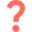
Проанализируйте и изложите содержательный смысл полученных
результатов.

*# WRITE YOUR ANSWER*

## **Часть 3.** Алгоритм UCR-DTW.

Третья часть практической работы посвящена алгоритму UCR-DTW, который использует нижние границы схожести $\text{LB}_{\text{Kim}}\text{FL}$, $\text{LB}_{\text{Keogh}}\text{EQ}$ и $\text{LB}_{\text{Keogh}}\text{EC}$, применяющиеся каскадным образом. Псевдокод алгоритма UCR-DTW представлен ниже.

<center><img src="https://github.com/mzym/TimeSeriesCourse/blob/main/practice/02%20Similarity%20search/img/ucr_dtw.png?raw=true" width="650"></center>

**Нижняя граница схожести (lower bound, LB)** представляет собой функцию, вычислительная сложность которой меньше вычислительной сложности меры DTW. Нижняя граница используется для отбрасывания кандидатов (подпоследовательностей временного ряда), заведомо не похожих на запрос, без вычисления меры DTW.

Нижние границы между кандидатом
$C$ и запросом $Q$ длины $n$, применяемые в UCR-DTW, вычисляются следующим образом:
<ul>
<li><b>Нижняя граница $\text{LB}_{\text{Kim}}\text{FL}$</b> определяется как сумма квадратов разностей между первыми и последними точками запроса $Q$ и
подпоследовательности $C$:
\begin{equation}
    \text{LB}_{\text{Kim}}\text{FL}(Q, C) = (q_1 - c_1)^2 + (q_n - c_n)^2.
\end{equation}
</li>

<li><b>Нижняя граница $\text{LB}_{\text{Keogh}}\text{EQ}$</b> показывает расстояние между верхней или нижней оболочкой $U$ и $L$, построенными вокруг запроса $Q$, и кандидатом $C$:
\begin{equation}
    \text{LB}_{\text{Keogh}}\text{EQ}(Q,C) = \sum_{i=1}^n{\left\{
            \begin{array}{cl}
            (c_i - u_i)^2, & \text{if} \; c_i > u_i \\
            (c_i - l_i)^2, & \text{if} \; c_i < l_i\\
            0, & \text{otherwise}.
            \end{array}
            \right.}
\end{equation}

Нижней и верхней оболочкой (lower and upper envelope) запроса $Q$ называют соответственно последовательности $L = (l_1,..., l_n)$ и $U = (u_1,..., u_n)$, вычисляемые как минимумы и максимумы запроса в скользящем окне заданной длины $r$ ($1 < r < m$):
\begin{equation}
    u_i = \max_{\max(1,i-r) \leqslant k \leqslant \min(m, i+r)} q_{k}, \\
    l_i = \min_{\max(1,i-r) \leqslant k \leqslant \min(m, i+r)} q_{k},
\end{equation}
где $r$ – ширина полосы Сако–Чиба.
</li>

<li><b>Нижняя граница $\text{LB}_{\text{Keogh}}\text{EC}$</b> представляет собой расстояние между запросом $Q$ и оболочкой кандидата $C$, т.е. является реверс-версией нижней границы $\text{LB}_{\text{Keogh}}\text{EQ}$:
\begin{equation}
    \text{LB}_{\text{Keogh}}\text{EC}(Q,C) = \text{LB}_{\text{Keogh}}\text{EQ}(C, Q).
\end{equation}
</li>
</ul>

### **Задача 7.**
  
Реализуйте технику каскадного применения нижних границ и сами нижние границы,  заполнив пропуски в классе `UCR_DTW`, в модуле *bestmatch.py*.
Выполните алгоритм UCR-DTW на данных ЭКГ из предыдущих частей, задав такие же значения входных параметров, что и для наивного алгоритма из части 2, и визуализируйте результаты. Убедитесь, что результаты UCR-DTW совпадают с результатами наивного алгоритма.

In [ ]:
top_k = 2
r = 0.01
excl_zone_frac = 1
is_normalize = True

ucr_dtw_results = {}

# INSERT YOUR CODE

Визуализируйте количество неотброшенных и отброшенных каждой нижней границей подпоследовательностей временного ряда в виде круговой диаграммы с помощью функции `pie_chart()` из модуля *plots.py*.

In [ ]:
# INSERT YOUR CODE

### **Задача 8.**

Проведите эксперименты, аналогичные тем, которые выполнялись для исследования эффективности наивного алгоритма в задаче 6. Постройте графики и вычислите ускорение алгоритма UCR-DTW относительно наивного алгоритма. Для справедливого сравнения алгоритмов используйте сгенерированные временные ряды и запросы из задачи 6.

Эксперимент 1

In [ ]:
algorithm = 'ucr-dtw'
algorithm_params = {
    'topK': 3,
    'excl_zone_frac': 1,
    'is_normalize': True,
}

n_list = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15] # lengths of time series
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
m = 2**6 # length of query

exp1_params = {
    'varying': {'n': n_list,
                'r': r_list},
    'fixed': {'m': m}
}
exp1_data = {
    'ts': dict.fromkeys(map(str, n_list), []),
    'query': {str(m): []}
}

task = 'best_match'

# generate set of time series and query
# run experiments for measurement of algorithm runtimes

# INSERT YOUR CODE

In [ ]:
#visualize plot with results of experiment
comparison_param = np.array(r_list)

# INSERT YOUR CODE

In [ ]:
# visualize table with speedup
tab_index = [f"n = {n}" for n in n_list]
tab_columns = [f"r = {r}" for r in r_list]
tab_title = "Speedup UCR-DTW relative to the naive algorithm <br> (variable time series length and warping path size, fixed query length)"

# INSERT YOUR CODE

Эксперимент 2

In [ ]:
m_list = [2**4, 2**5, 2**6, 2**7, 2**8] # lengths of query
r_list = np.round(np.arange(0, 0.6, 0.1), 2).tolist() # sizes of warping window
n = 2**12 # length of time series

exp_params = {
    'varying': {'m': m_list,
                'r': r_list},
    'fixed': {'n': n}
}
data = {
    'ts': {str(n): []},
    'query': dict.fromkeys(map(str, m_list), []),
}

# INSERT YOUR CODE

In [ ]:
comparison_param = np.array(r_list)

# INSERT YOUR CODE

In [ ]:
tab_index = [f"m = {m}" for m in m_list]
tab_columns = [f"r = {r}" for r in r_list]
tab_title = "Speedup UCR-DTW relative to the naive algorithm <br> (variable query length and warping path size, fixed time series length)"

# INSERT YOUR CODE

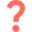
Проанализируйте и изложите содержательный смысл полученных
результатов.

*# WRITE YOUR ANSWER*

### **Задача 9.**

В данном задании вам предстоит определелить, какую функцию расстояния ED или DTW лучше всего использовать на практике для поиска наиболее похожих подпоследовательностей временного ряда на запрос. Чтобы это сделать, рассмотрим две задачи из различных предметных областей, решить которые предлагается с помощью алгоритмов поиска по образцу.

Начнем с **первой задачи из области физиологии человека**. На человеке сначала закрепляют множество акселерометров и гироскопов, после чего он выполняет в помещении последовательность заранее определенных действий (активностей) в течение некоторого промежутка времени. Примерами таких активностей являются открывание/закрывание дверей, включение/выключение света, питье из чашки стоя/сидя и др. В то время как человек выполняет эти активности, датчики фиксируют его скорость и направление наклона тела. Задача дата-сайентиста заключается в том, что необходимо распознать в снятых данных все активности, которые выполнял человек.  

Данную задачу упростим, и будем выполнять поиск только одной активности во временном ряде при условии, что у нас имеется образец этой активности. В качестве данных возьмем временной ряд показаний гироскопа, закрепленного на правом запятье руки человека, из набора данных [Opportunity](https://archive.ics.uci.edu/dataset/226/opportunity+activity+recognition) и образец искомой активности, питья из чашки стоя. Данный ряд соответствует примерно 14-минутной записи.

Загрузите временной ряд и образец поиска из директории `./datasets/part3/Opportunity` в ноутбук.    

In [ ]:
# INSERT YOUR CODE

Выполните поиск похожих подпоследовательностей на запрос с помощью реализованных вами ранее алгоритмов MASS и UCR-DTW. Согласно истинной разметке, искомую активность человек выполнял 7 раз, поэтому параметр $topK=7$.

In [ ]:
topK = 7
r = 0.1
excl_zone_frac = 1
is_normalize = True

# INSERT YOUR CODE

Чтобы оценить качество распознавания активности, загрузите имеющуюся истинную разметку, хранящуюся в файле *labels.csv*. В разметке значением 1 обозначаются моменты времени, когда человек пил из чашки стоя, и значением 0 – в противном случае. Вычислите среди найденных $topK$ подпоследовательностей количество TP (True Positive) и FN (False Negative) с помощью функции `calculate_task1_accuracy()` и сравните между собой показатели, полученные с помощью MASS и UCR-DTW.

In [ ]:
def calculate_task1_accuracy(labels: np.array, predicted_results: np.array) -> dict:
    """
    Calculate the accuracy of the algorithm which performs the activity recognition

    Parameters
    ----------
    labels: true labels
    predicted_results: results are predicted by algorithm

    Returns
    -------
        The number of True Positive and False Negative examples
    """

    TP = 0
    FN = 0

    topK = len(predicted_results['indices'])

    for i in range(topK):
        idx = predicted_results['indices'][i]
        if (labels[idx] == 1):
            TP = TP + 1

    FN = topK - TP

    return {'TP': TP,
            'FN': FN}

In [ ]:
# INSERT YOUR CODE

Итоговый вывод о преимуществе одной функции расстояния над другой в задаче поиска по образцу на данный момент делать еще рано, поэтому решим **вторую задачу из области транспорта**. Данная задача заключается в прогнозировании потока пешеходов в некоторой точке города на основе прошлых данных.

Прогнозирование ряда $T$ длины $n$ будем выполнять следующим образом. Сначала сформируем запрос $Q$, состоящий из $m$ последних по времени элементов ряда, $Q = T_{n-m+1,m}$. Далее среди всех подпоследовательностей ряда $T$, начинающихся с 1 до $n-2m$ позиций, найдем $topK$ похожих на запрос $Q$. Обозначим за $h > 0$ горизонт прогнозирования, определяющий количество элементов ряда, значения которых необходимо спрогнозировать. Для нахождения будущих значений будем брать $h$ элементов ряда, которые следуют за концевыми точками найденных похожих подпоследовательностей. В итоге, будущие значения будут получаться путем применения агрегатной функции к этим элементам. В качестве агрегатной функции может использоваться среднее арифметическое, взвешенное среднее, медиана и др.

Загрузите временной ряд из файла *pedestrian_count.csv*, расположенного в директории *./datasets/part3/Melbourne*. Данный ряд содержит почасовую статистику о количестве пешеходов на улице Бурке в Мельбурне (Австралия), являющейся одной из главных улиц города. Данные собраны за период с 1 марта 2020 по 31 октября 2022 гг. Полный набор данных и его детальное описание доступны по следующей [ссылке](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/).

In [ ]:
data_path = './datasets/part3/Melbourne/pedestrian_count.csv'

data = pd.read_csv(data_path, header=0)

Реализуйте алгоритм прогнозирования временного ряда на основе UCR-DTW и MASS, следуя приведенному выше описанию. За прогнозирование отвечает класс `BestMatchPredictor` из модуля *prediction.py*, дополните его недостающим кодом.  

Далее выполните прогнозирование потока людей для исходных данных на 1 день вперед (24 значения). Для этого установите следующие входные параметры:
<ul>
  <li>$h = 24$ (горизонт прогнозирования);</li>
  <li>$m = 168$ (длина запроса и подпоследовательностей, соответствующая 1 неделе);</li>
  <li>$aggr\_func = \text{'average'}$ (агрегатная функция);</li>
  <li>для алгоритма UCR-DTW:
    <ul>
      <li>$topK = 5$ (количество похожих подпоследовательностей на запрос);</li>
      <li>$r = 0.1$ (ширина полосы Сако–Чиба);</li>
      <li>$excl\_zone\_frac = 1$ (доля от длины подпоследовательностей, на основе которой определяется, являются ли подпоследоватлеьности тривиальными совпадениями);</li>
      <li>$is\_normalize = True$ ($z$-нормализация запроса и подпоследовательностей);</li>
    </ul>
  </li>
  <li>для алгоритма MASS:</li>
    <ul>
      <li>$topK = 5$ (количество похожих подпоследовательностей на запрос);</li>
      <li>$excl\_zone\_frac = 1$ (доля от длины подпоследовательностей, на основе которой определяется, являются ли подпоследоватлеьности тривиальными совпадениями).</li>
    </ul>
</ul>

Будем считать, что последние $h$ значений в загруженном временном ряде $T$ длины $n$ отсутствуют. Поэтому перед тем как находить прогнозные значения,  подготовьте данные. Разделите загруженный временной ряд $T$ на три части:
<ol>
  <li>ряд $T_{train}$, в котором будет выполняться поиск похожих подпоследовательностей на запрос $Q$: $T_{train} = T[0:(n-m-h)]$</li>
  <li>запрос $Q$: $Q = T[(n-m-h) : (n-h)]$</li>
  <li>реальные значения ряда $real\_values$, которые необходимо спрогнозировать: $real\_values = T[-h:] $</li>
</ol>

In [ ]:
ucr_dtw_params = {
    'topK': # INSERT VALUE,
    'r': # INSERT VALUE,
    'excl_zone_frac': # INSERT VALUE,
    'is_normalize': # INSERT VALUE
}

# INSERT YOUR CODE

In [ ]:
mass_params = {
    'topK': # INSERT VALUE,
    'excl_zone_frac': # INSERT VALUE
}

# INSERT YOUR CODE

Далее выполните сравнение эффективности алгоритма при UCR-DTW и MASS по точности прогнозирования. Для оценки точности используйте **меру
среднеквадратичной ошибки RMSE (Root Mean Square Error)**, которая определяется следующим образом:
\begin{equation}
RMSE = \sqrt{\frac{1}{h}\sum_{i=1}^h{(t_i-\tilde{t}_i)}^2},
\end{equation}
где $t_i$ и $\tilde{t}_i$ — фактическое и прогнозное значения элемента ряда, $h$ — количество прогнозных элементов временного ряда.

In [ ]:
from sklearn.metrics import mean_squared_error

# INSERT YOUR CODE

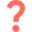 Сделайте вывод о влиянии функции расстояния ED и DTW на точность решения задач интеллектульного анализа данных, которые основаны на алгоритмах поиска по образцу.  

*# WRITE YOUR ANSWER*

# 